# Локализатор цифр на изображении

In [191]:
import skimage
from skimage import io
from skimage import color
from skimage import filters
from skimage.color import rgb2gray
from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.morphology import (erosion, dilation, closing, opening,
                                area_closing, area_opening)
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread, imshow
import numpy as np
import pandas as pd 
from scipy.cluster.vq import whiten 
from sklearn.cluster import KMeans

In [151]:
dir_src = '/home/skywatcher/Документы/Практика/PetProjects/Numbers/Research/img/'
img = skimage.io.imread(dir_src + 'all_digits.jpg')

### Разделим изображение на цвета

In [154]:
r, g, b = [], [], []

In [155]:
for row in img:
    for r_val, g_val, b_val in row:
        r.append(r_val)
        g.append(g_val)
        b.append(b_val)

In [156]:
print(len(r), len(g), len(b))

1228800 1228800 1228800


In [157]:
color_df = pd.DataFrame({'red': r,
                         'green': g,
                         'blue': b})

### Оценим масштаб цветов

In [158]:
color_df['scaled_red'] = whiten(color_df.red)
color_df['scaled_green'] = whiten(color_df.green)
color_df['scaled_blue'] = whiten(color_df.blue)

In [159]:
color_df

,red,green,blue,scaled_red,scaled_green,scaled_blue
0,225,221,212,8.595885,8.488775,8.163427
1,233,229,220,8.901516,8.796061,8.471481
2,222,218,209,8.481273,8.373543,8.047907
3,219,215,206,8.366661,8.258311,7.932387
4,204,200,191,7.793602,7.682150,7.354786
...,...,...,...,...,...,...
1228795,142,147,140,5.424959,5.646380,5.390943
1228796,143,148,141,5.463162,5.684791,5.429449
1228797,145,150,143,5.539570,5.761612,5.506463
1228798,142,147,140,5.424959,5.646380,5.390943


### Найдем цветовые кластеры в изображении
Которые нужны вдальнейшем для фильтрации изображения

In [161]:
kmeans_arr = KMeans(n_clusters=8).fit(color_df[['scaled_red',
                                                    'scaled_green',
                                                    'scaled_blue']])

In [162]:
cluster_centers = kmeans_arr.cluster_centers_

In [163]:
color_df['kmean_label'] = kmeans_arr.predict(color_df[['scaled_red',
                                                    'scaled_green',
                                                    'scaled_blue']])

In [164]:
main_colors = []

red_std, green_std, blue_std = color_df[['red',
                                         'green',
                                         'blue']].std()

for cluster_center in cluster_centers:
    red_scaled, green_scaled, blue_scaled = cluster_center
    main_colors.append([
        red_scaled*red_std/255,
        green_scaled*green_std/255,
        blue_scaled*blue_std/255
    ])

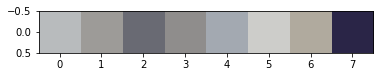

In [165]:
plt.imshow([main_colors])
plt.show()

In [166]:
main_colors[6]

[0.6908658190910067, 0.6678037498086904, 0.6216757404484694]

In [167]:
np_main_color = np.array(main_colors)

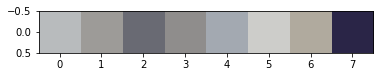

In [168]:
plt.imshow([np_main_color])
plt.show()

### Обозначим диапазон фильтра чернил

In [178]:
color_rgb = (np_main_color*255).round().astype(int).tolist()

In [179]:
ink_max = color_df[color_df['kmean_label']==7][['red','green', 'blue']].max().values.tolist()

In [180]:
ink_max

[84, 80, 122]

In [181]:
ink_min = color_df[color_df['kmean_label']==7][['red','green', 'blue']].min().values.tolist()

In [182]:
ink_min

[0, 0, 0]

### Наложим фильтр

In [188]:
masked_img = np.where((ink_min<=img)&(img<=ink_max), [0,255,0], [0,0,0])

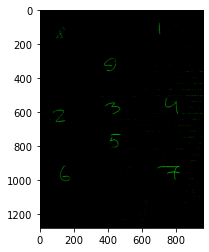

In [189]:
imshow(masked_img);

In [190]:
# fig, axs = plt.subplots(33,3, figsize=(20,100), facecolor='w', edgecolor='k')

# axs = axs.ravel()
# for i in range(99):
#     ax = fig.add_subplot(33,3, i+1)
#     ax.set_title(i/100)
#     ax.imshow(img_g<(i/100))